In [1]:
import torch

from models.mmppp import MMPpp
from models.modules import FC_vec

from loader.Toy_dataset import Toy, toy_visualizer, pallete
from models.lbf import LfD, Gaussian_basis, phi, vbf

import matplotlib.pyplot as plt

import numpy as np

device = 'cuda:0'

Toy split training | torch.Size([15, 201, 2])


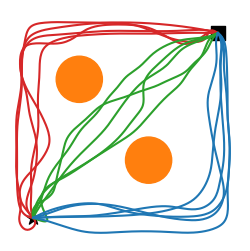

In [2]:
ds = Toy(root='datasets/EXP2')

fig, axs = plt.subplots(1, 1, figsize=(12, 3))
toy_visualizer(ds.env, axs, traj=ds.data, label=ds.targets)

In [3]:
w = LfD(ds.data, mode='vmp', via_points=[[0.8, 0.8], [-0.8, -0.8]])

In [4]:
z = torch.linspace(0, 1, 100).view(1, -1, 1)
basis_values = Gaussian_basis(z)
phi_values = phi(basis_values)
vmp_recon_curve = vbf(z, phi_values, w, via_points=[[0.8, 0.8], [-0.8, -0.8]])

Toy split training | torch.Size([15, 201, 2])


Text(0.5, 1.0, 'VMP recon trajectories')

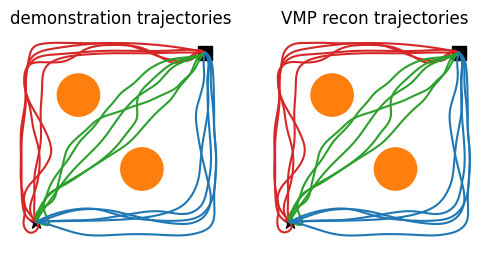

In [5]:
ds = Toy(root='datasets/EXP2')
dl = torch.utils.data.DataLoader(ds, batch_size=5)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
toy_visualizer(ds.env, axs[0], traj=ds.data, label=ds.targets)
toy_visualizer(ds.env, axs[1], traj=vmp_recon_curve, label=ds.targets)
axs[0].set_title("demonstration trajectories")
axs[1].set_title("VMP recon trajectories")

In [6]:
encoder = FC_vec(
    in_chan=60,
    out_chan=2,
    l_hidden=[512, 512],
    activation=['elu', 'elu'],
    out_activation='linear'
)
decoder = FC_vec(
    in_chan=2,
    out_chan=60,
    l_hidden=[512, 512],
    activation=['elu', 'elu'],
    out_activation='linear'
)

mmppp = MMPpp(
    encoder,
    decoder,
    dof=2,
    b=30,
    h_mul=1,
    basis='Gaussian',
    mode='vmp',
    via_points=[[0.8, 0.8], [-0.8, -0.8]]
)
mmppp.to(device)

MMPpp(
  (encoder): FC_vec(
    (net): Sequential(
      (0): Linear(in_features=60, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): FC_vec(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=512, out_features=60, bias=True)
    )
  )
)

In [7]:
opt = torch.optim.Adam(mmppp.parameters(), lr=0.0001)
for epoch in range(1000):
    for x, y in dl:
        train_results = mmppp.train_step(x.to(device), optimizer=opt)
        train_loss = train_results["loss"]
    if epoch%100 == 0:
        print(f"[Epoch: {epoch}] Loss: {train_loss}")

[Epoch: 0] Loss: 5.263613224029541
[Epoch: 100] Loss: 0.08985089510679245
[Epoch: 200] Loss: 0.054717835038900375
[Epoch: 300] Loss: 0.010813492350280285
[Epoch: 400] Loss: 0.006345028523355722
[Epoch: 500] Loss: 0.0037600714713335037
[Epoch: 600] Loss: 0.0024905740283429623
[Epoch: 700] Loss: 0.0015673702582716942
[Epoch: 800] Loss: 0.0010213801870122552
[Epoch: 900] Loss: 0.0006132549024187028


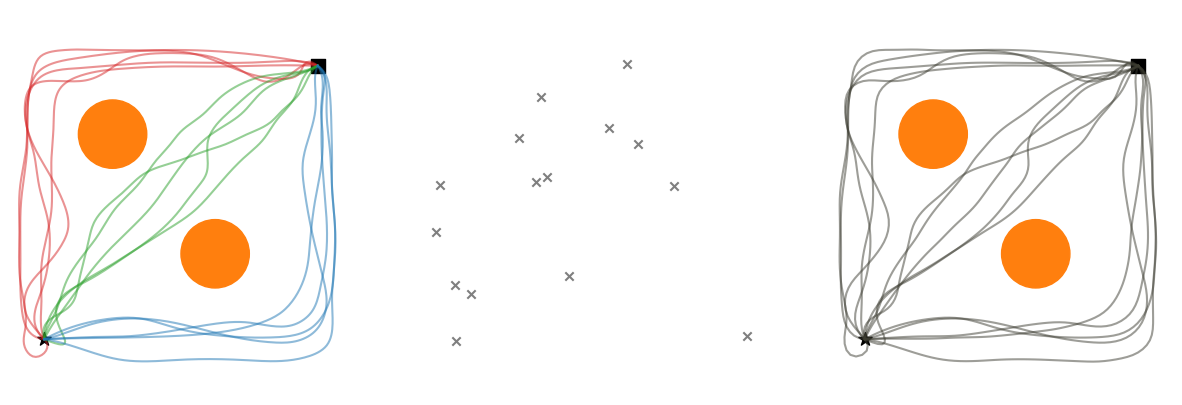

In [29]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c='tab:gray',
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()
sample_y = dict_samples['cluster_samples'].numpy()

recon_w = mmppp.decode(mmppp.encode(mmppp.get_w_from_traj(ds.data.to(device)))).detach().cpu()
z = torch.linspace(0, 1, 100).view(1, -1, 1)
basis_values = Gaussian_basis(z)
phi_values = phi(basis_values)
vmp_recon_curve = vbf(z, phi_values, recon_w.view(len(recon_w), -1, 2), via_points=[[0.8, 0.8], [-0.8, -0.8]])

toy_visualizer(
    ds.env, 
    axs[2], 
    traj=vmp_recon_curve, 
    label=torch.tensor(len(ds.targets)*[10]), 
    alpha=alpha1)

C:\Users\21448\AppData\Local\Temp\ipykernel_31892\1274850978.py:57: UserWarning: No contour levels were found within the data range.
  contour = axs[1].contour(


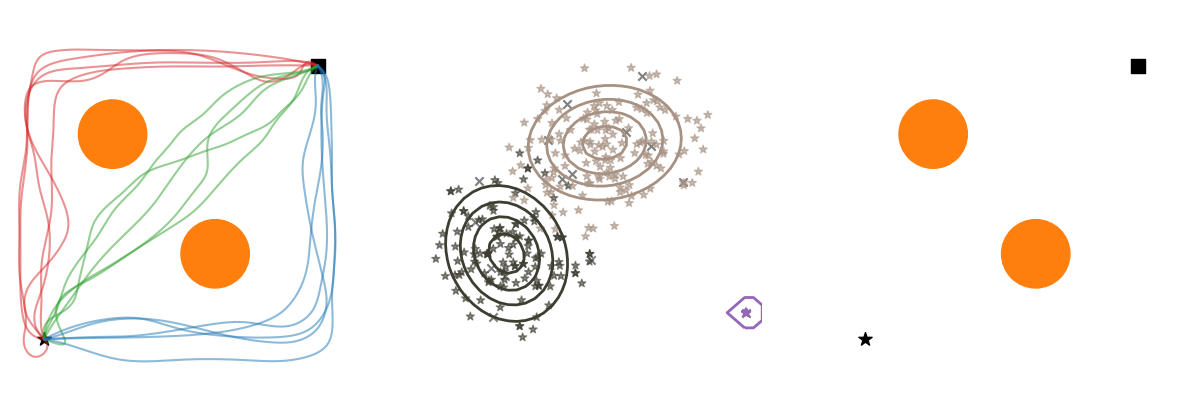

In [34]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c='tab:gray',
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()
sample_y = dict_samples['cluster_samples'].numpy()

axs[1].scatter(
    z_samples[:,0], 
    z_samples[:,1],
    c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
    alpha=0.6,
    marker='*',
    )

sample_y = dict_samples['cluster_samples'].numpy()

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()
for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
    tempZ = z_samples[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=pallete[10-i],
        linewidths=2,
        )
    
recon_w = mmppp.decode(mmppp.encode(mmppp.get_w_from_traj(ds.data.to(device)))).detach().cpu()
z = torch.linspace(0, 1, 100).view(1, -1, 1)
basis_values = Gaussian_basis(z)
phi_values = phi(basis_values)
vmp_recon_curve = vbf(z, phi_values, recon_w.view(len(recon_w), -1, 2), via_points=[[0.8, 0.8], [-0.8, -0.8]])

toy_visualizer(
    ds.env, 
    axs[2], 
    traj=torch.tensor([]), 
    label=torch.tensor([]), 
    alpha=alpha1)

C:\Users\21448\AppData\Local\Temp\ipykernel_31892\4215226242.py:56: UserWarning: No contour levels were found within the data range.
  contour = axs[1].contour(


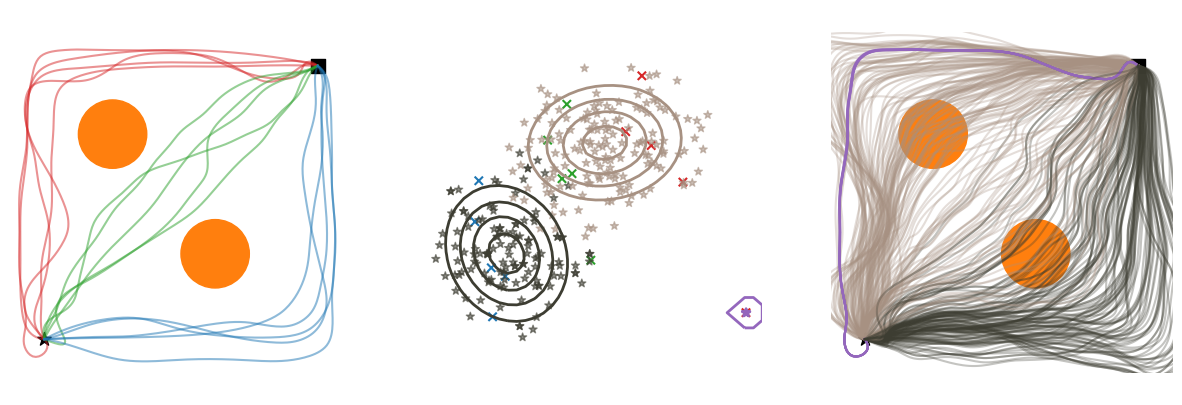

In [35]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()

axs[1].scatter(
    z_samples[:,0], 
    z_samples[:,1],
    c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
    alpha=0.6,
    marker='*',
    )

sample_y = dict_samples['cluster_samples'].numpy()

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()
for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
    tempZ = z_samples[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=pallete[10-i],
        linewidths=2,
        )
    
toy_visualizer(
    ds.env, 
    axs[2], 
    traj=q_traj, 
    label=10-dict_samples['cluster_samples'], 
    alpha=alpha2)

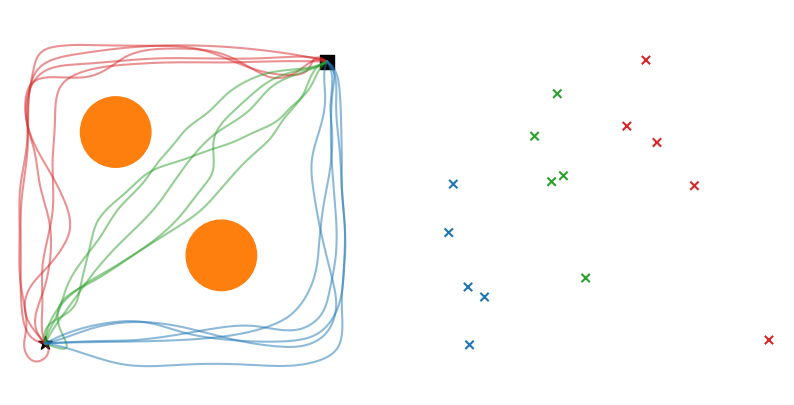

In [40]:
n_components = 3
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()

# axs[1].scatter(
#     z_samples[:,0], 
#     z_samples[:,1],
#     c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
#     alpha=0.6,
#     marker='*',
#     )

# sample_y = dict_samples['cluster_samples'].numpy()

# xmin, xmax = axs[1].get_xbound()
# ymin, ymax = axs[1].get_ybound()
# for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
#     tempZ = z_samples[sample_y == i]
#     x = np.linspace(xmin, xmax, 40)
#     y = np.linspace(ymin, ymax, 40)
#     xx, yy = np.meshgrid(x, y) 
#     delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

#     zz = np.exp(np.diagonal(
#         -(delta@np.linalg.inv(cov)@delta.transpose())
#     )/2)
    
#     c = sample_y[sample_y == i].reshape(-1,1)
#     contour = axs[1].contour(
#         xx.reshape(40, 40), 
#         yy.reshape(40, 40), 
#         zz.reshape(40, 40),
#         levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
#         colors=pallete[10-i],
#         linewidths=2,
#         )
    
# toy_visualizer(
#     ds.env, 
#     axs[2], 
#     traj=q_traj, 
#     label=10-dict_samples['cluster_samples'], 
#     alpha=alpha2)